[CNN 기반 성별 분류 예측 모델 ] <hr>

- 다양한 성별과 국가의 남성/여성 이미지 데이터셋 CSV 
- 사용자 정의 CNN 기반 모델

< 모듈 및 데이터 로딩 > <hr>

In [32]:
# [1-1] 모듈 로딩
import torch                         # PyTorch: 딥러닝 프레임워크
import torch.nn as nn                # PyTorch: 신경망 관련 모듈
import torch.nn.functional as F      # PyTorch: 유용한 함수 (활성화 함수 등)

from torchvision.datasets import ImageFolder      # PyTorch: 이미지 데이터셋을 폴더 구조로 생성
from torch.utils.data import DataLoader           # PyTorch: 데이터셋을 배치로 로딩하기 위한 클래스
from torchvision.transforms import transforms     # PyTorch: 이미지 전처리 및 데이터 증강을 위한 클래스/함수  

import matplotlib.pyplot as plt                   # Matplotlib: 데이터 및 결과 시각화
import koreanize_matplotlib                       # Matplotlib: 한글 폰트 설정 및 한글화 모듈

from collections import Counter                   # Python 내장 라이브러리: 요소 비율 계산 (데이터 분석용)

from sklearn.model_selection import train_test_split            # Scikit-learn: 데이터셋을 학습/테스트셋으로 분리하는 함수
from torch.utils.data import DataLoader, TensorDataset, Subset  # PyTorch: 데이터로딩 및 데이터셋 관련 클래스/함수
from sklearn.model_selection import train_test_split            # Scikit-learn: 학습/테스트셋 분리 반복 필요 시 재호출 가능

from torchinfo import summary                   # PyTorch: 모델 정보 요약 및 가시화
import torch.optim as optim                     # PyTorch: 최적화 알고리즘 관련 클래스

from torch.utils.data import Dataset, DataLoader               # PyTorch: 데이터셋 정의 및 배치 로더 관련 클래스
import torchmetrics.functional as mt                           # PyTorch Metrics: 함수형 모듈 (정확도 등)
from torchmetrics.classification import *                      # PyTorch Metrics: 분류 관련 메트릭스 클래스 및 함수

from torchmetrics.classification import BinaryAccuracy         # PyTorch Metrics: 이진 분류 정확도 계산 클래스

from torch.optim.lr_scheduler import ReduceLROnPlateau         # PyTorch: 학습률 감소 스케줄링 클래스

from PIL import Image               # Python Imaging Library: 이미지 파일 로드 및 처리

import pandas as pd                 # Pandas: 데이터프레임 생성 및 데이터 분석
import numpy as np                  # Numpy: 수치 데이터 처리 및 배열 계산

from sklearn.preprocessing import LabelEncoder   # Scikit-learn: 문자열로 된 라벨을 숫자로 변환하는 인코더 클래스


In [33]:
# [1-2] 데이터 로딩
gender_df = pd.read_csv('exceptbaby.csv')

In [34]:
# [1-3] 데이터 확인
display(gender_df)

,age,ethnicity,gender,pixels
0,10,0,0,30 38 50 90 109 113 126 130 136 139 147 149 15...
1,10,0,0,72 81 94 96 77 85 90 71 76 90 87 80 91 103 118...
2,10,0,0,255 253 252 221 144 174 165 151 151 186 185 14...
3,10,0,0,62 53 55 62 73 74 86 94 106 121 139 161 170 15...
4,10,0,0,28 60 55 55 74 74 62 101 147 140 166 147 161 1...
...,...,...,...,...
22577,99,0,1,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
22578,99,1,1,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
22579,99,2,1,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
22580,99,2,1,45 108 120 156 206 197 140 180 191 199 204 207...


In [35]:
# [1-4] pixel 열 리스트화 
gender_df['pixels']=gender_df['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

In [36]:
print(type(gender_df['pixels'].iloc[0])) 

<class 'numpy.ndarray'>


In [37]:
display(gender_df)

,age,ethnicity,gender,pixels
0,10,0,0,"[30.0, 38.0, 50.0, 90.0, 109.0, 113.0, 126.0, ..."
1,10,0,0,"[72.0, 81.0, 94.0, 96.0, 77.0, 85.0, 90.0, 71...."
2,10,0,0,"[255.0, 253.0, 252.0, 221.0, 144.0, 174.0, 165..."
3,10,0,0,"[62.0, 53.0, 55.0, 62.0, 73.0, 74.0, 86.0, 94...."
4,10,0,0,"[28.0, 60.0, 55.0, 55.0, 74.0, 74.0, 62.0, 101..."
...,...,...,...,...
22577,99,0,1,"[127.0, 100.0, 94.0, 81.0, 77.0, 77.0, 74.0, 9..."
22578,99,1,1,"[23.0, 28.0, 32.0, 35.0, 42.0, 47.0, 68.0, 85...."
22579,99,2,1,"[59.0, 50.0, 37.0, 40.0, 34.0, 19.0, 30.0, 101..."
22580,99,2,1,"[45.0, 108.0, 120.0, 156.0, 206.0, 197.0, 140...."


gender
0    11746
1    10836
Name: count, dtype: int64


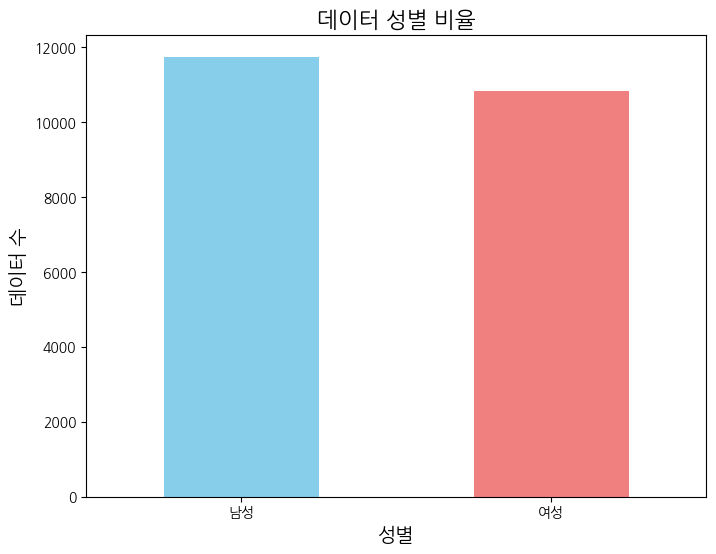

In [38]:
# [1-4] 데이터 불균형 확인

print(gender_df['gender'].value_counts())

# gender 컬럼의 value_counts 결과
gender_counts = gender_df['gender'].value_counts()

# 시각화
plt.figure(figsize=(8, 6))
gender_counts.plot(kind='bar', color=['skyblue', 'lightcoral']) 
plt.title('데이터 성별 비율', fontsize=16)
plt.xlabel('성별', fontsize=14)
plt.ylabel('데이터 수', fontsize=14)
plt.xticks(rotation=0)
plt.xticks(ticks=[0, 1], labels=['남성', '여성']) # x축 라벨을 숫자 대신 의미로 표시
plt.show()

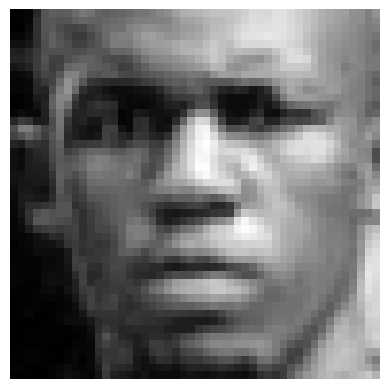

In [39]:
# [1-5] 실제 데이터 확인
# array 배열 형태로 변환
X = np.array(gender_df['pixels'].tolist())

# 차원 변환 
X = X.reshape(X.shape[0],48,48,1)

# 시각화 
plt.imshow(X[4000].reshape(48, 48), cmap='gray')  # X[0]을 2D로 변환하고 흑백으로 표시
plt.axis('off')  # 축 제거
plt.show()


In [40]:
# [1-6] 결측치 확인 : 없음
print(gender_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22582 entries, 0 to 22581
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        22582 non-null  int64 
 1   ethnicity  22582 non-null  int64 
 2   gender     22582 non-null  int64 
 3   pixels     22582 non-null  object
dtypes: int64(3), object(1)
memory usage: 705.8+ KB
None


< 피쳐와 타겟 분리> <hr>

In [41]:
# [2-1] 피쳐 타겟 분리 
featureDF = pd.DataFrame(gender_df['pixels'].tolist())
targetSR = gender_df['gender']   # 타겟 : 1차원

# 숫자 맞는지, 차원 맞는지 확인해주기
print(f'featureDF : {featureDF.shape}, targetSR : {targetSR.shape}')
print(f'featureDF : {featureDF.ndim}, targetSR : {targetSR.ndim}')

featureDF : (22582, 2304), targetSR : (22582,)
featureDF : 2, targetSR : 1


In [42]:
# [2-2] 피쳐 전처리 

# 정규화 
# 0 ~ 255 -> 0.0 ~ 1.0 정규화 : 효율 증대
featureDF = featureDF/255.  # 정규화 과정에서 데이터프레임이나 배열의 모든 값이 동일한 타입으로 처리되도록 보장

featureDF

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,0.117647,0.149020,0.196078,0.352941,0.427451,0.443137,0.494118,0.509804,0.533333,0.545098,...,0.274510,0.250980,0.231373,0.200000,0.176471,0.321569,0.498039,0.478431,0.466667,0.215686
1,0.282353,0.317647,0.368627,0.376471,0.301961,0.333333,0.352941,0.278431,0.298039,0.352941,...,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078
2,1.000000,0.992157,0.988235,0.866667,0.564706,0.682353,0.647059,0.592157,0.592157,0.729412,...,0.501961,0.490196,0.505882,0.517647,0.501961,0.482353,0.462745,0.435294,0.501961,0.470588
3,0.243137,0.207843,0.215686,0.243137,0.286275,0.290196,0.337255,0.368627,0.415686,0.474510,...,0.584314,0.788235,0.894118,0.952941,0.980392,0.980392,0.976471,0.984314,0.988235,0.976471
4,0.109804,0.235294,0.215686,0.215686,0.290196,0.290196,0.243137,0.396078,0.576471,0.549020,...,0.078431,0.121569,0.188235,0.380392,0.670588,0.670588,0.678431,0.670588,0.678431,0.690196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22577,0.498039,0.392157,0.368627,0.317647,0.301961,0.301961,0.290196,0.388235,0.400000,0.384314,...,0.066667,0.066667,0.078431,0.074510,0.074510,0.231373,0.360784,0.372549,0.368627,0.411765
22578,0.090196,0.109804,0.125490,0.137255,0.164706,0.184314,0.266667,0.333333,0.384314,0.403922,...,0.317647,0.294118,0.290196,0.294118,0.278431,0.286275,0.282353,0.282353,0.333333,0.376471
22579,0.231373,0.196078,0.145098,0.156863,0.133333,0.074510,0.117647,0.396078,0.611765,0.666667,...,0.086275,0.094118,0.054902,0.109804,0.215686,0.329412,0.419608,0.384314,0.305882,0.305882
22580,0.176471,0.423529,0.470588,0.611765,0.807843,0.772549,0.549020,0.705882,0.749020,0.780392,...,0.031373,0.054902,0.105882,0.254902,0.301961,0.364706,0.231373,0.125490,0.137255,0.137255


In [43]:
# [2-3] 타겟 전처리 
lencoder = LabelEncoder()
lencoder.fit(targetSR)
targetSR = lencoder.transform(targetSR)

# 확인 
print(lencoder.classes_)

[0 1]


In [44]:
targetSR = pd.Series(targetSR)
targetSR

0        0
1        0
2        0
3        0
4        0
        ..
22577    1
22578    1
22579    1
22580    1
22581    1
Length: 22582, dtype: int64

In [45]:
# [2-4] 학습용, 검증용 데이터셋 분리

# 분류 : stratify=targetSR
x_train ,x_valid, y_train, y_valid = train_test_split(featureDF, targetSR,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=targetSR)

print(f'x_train : {x_train.shape}   y_train : {y_train.shape}')
print(f'x_valid : {x_valid.shape}   y_valid : {y_valid.shape}')

x_train : (18065, 2304)   y_train : (18065,)
x_valid : (4517, 2304)   y_valid : (4517,)


In [46]:
# [2-5] 인덱스 리셋
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

x_valid.reset_index(drop=True, inplace=True)
y_valid.reset_index(drop=True, inplace=True)

< 데이터셋, 데이터로더 생성 >  <hr>

In [47]:
# [3-1] 전용 데이터셋 클래스 
class GenderDataset(Dataset):

    # 피쳐와 타겟 분리 및 전처리 진행 
    def __init__(self, featureDF, targetSR):
        super().__init__()
        
        self.feature = featureDF
        self.target  = targetSR
        self.rows = featureDF.shape[0]
        self.cols = featureDF.shape[1]
        
    
    # 데이터셋의 샘플 수 반환 메서드 
    def __len__(self):
        return self.rows 

    # DataLoader에서 batch_size만큼 호출하는 메서드
    # 인덱스에 해당하는 피쳐와 타겟 반환 단, Tensor 형태
    def __getitem__(self, index):
       arrFeature = self.feature.iloc[index].values   # ndarray
       arrTarget = self.target[index].reshape(-1)     # ndarray
   
       return torch.FloatTensor(arrFeature), torch.Tensor(arrTarget)

In [48]:
# [3-2] 데이터셋 생성
## 확인 => Train용 DataSet 필수 
##      => Test용 Dataset 선택 => 데이터가 많다면 DS, DL 생성 사용
##                            => 데이터가 많지 않다면 DS, DL 생성 필요 X 
trainDS = GenderDataset(x_train, y_train)
validDS = GenderDataset(x_valid, y_valid)

print(trainDS[1])
print(validDS[1])

(tensor([0.0784, 0.1059, 0.0863,  ..., 0.0627, 0.1294, 0.1412]), tensor([1.]))
(tensor([0.6000, 0.6157, 0.6235,  ..., 0.6000, 0.5961, 0.5961]), tensor([1.]))


In [49]:
# [3-3] 데이터로더 생성 
# train
trainDL = DataLoader(dataset=trainDS, batch_size=3)

for feature, label in trainDL:
    print(feature, label, sep='\n')
    break

# valid
validDL = DataLoader(dataset=validDS, batch_size=3)

for feature, label in validDL:
    print(feature, label, sep='\n')
    break

feature.shape

tensor([[0.1098, 0.0824, 0.0353,  ..., 0.0627, 0.0667, 0.0353],
        [0.0784, 0.1059, 0.0863,  ..., 0.0627, 0.1294, 0.1412],
        [0.1922, 0.2078, 0.2235,  ..., 0.0588, 0.0588, 0.0667]])
tensor([[1.],
        [1.],
        [0.]])
tensor([[0.3451, 0.3412, 0.3020,  ..., 0.1294, 0.1922, 0.2941],
        [0.6000, 0.6157, 0.6235,  ..., 0.6000, 0.5961, 0.5961],
        [0.1765, 0.1882, 0.1451,  ..., 0.0118, 0.2039, 0.1961]])
tensor([[0.],
        [1.],
        [0.]])


torch.Size([3, 2304])

In [50]:
for feature, target in trainDL: 
    print(feature.shape)

torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size([3, 2304])
torch.Size

< 학습 진행 >  <hr>

In [51]:
# [4-1] CNN 클래스 정의 
class GenCNN(nn.Module):
    def __init__(self):
        super(GenCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=1),   # (3,1,48,48)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                    # (3,32,48,48) -> (3,32,24,24)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),   # (3,32,24,24)  ->  (3,64,24,24)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                     # (3,64,12,12)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),   # (3,128,12,12)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                      # (3,128,6,6)
        )
        
    
        
        self.fc1 = nn.Linear(128*6*6, 400)
        self.drop = nn.Dropout(0.4)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 1)  # 최종 출력은 1개로 설정
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = torch.flatten(x, 1)  
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))  
        return x

In [52]:
# [4-2] 학습 준비 
LR = 0.001
model = GenCNN()               # 학습 모델
OPTIMIZER = optim.Adam(model.parameters(),lr=LR)   # 최적화, 즉 경사하강법 알고리즘으로 W,b의 값 갱신 
LOSS_FN = nn.BCELoss()      
EPOCHS = 50
BATCH_SIZE = 128
ITERATION = int(len(trainDS) / BATCH_SIZE)
LR = 0.01
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [53]:
# [4-3] 확인 
summary(model, input_size=(3,1,48,48))

Layer (type:depth-idx)                   Output Shape              Param #
GenCNN                                   [3, 1]                    --
├─Sequential: 1-1                        [3, 32, 24, 24]           --
│    └─Conv2d: 2-1                       [3, 32, 48, 48]           320
│    └─BatchNorm2d: 2-2                  [3, 32, 48, 48]           64
│    └─ReLU: 2-3                         [3, 32, 48, 48]           --
│    └─MaxPool2d: 2-4                    [3, 32, 24, 24]           --
├─Sequential: 1-2                        [3, 64, 12, 12]           --
│    └─Conv2d: 2-5                       [3, 64, 24, 24]           18,496
│    └─BatchNorm2d: 2-6                  [3, 64, 24, 24]           128
│    └─ReLU: 2-7                         [3, 64, 24, 24]           --
│    └─MaxPool2d: 2-8                    [3, 64, 12, 12]           --
├─Sequential: 1-3                        [3, 128, 6, 6]            --
│    └─Conv2d: 2-9                       [3, 128, 12, 12]          73,856
│    

In [54]:
# [4-4] 학습 함수

def training():
    # 학습 모드 설정
    model.train()

    E_LOSS, E_ACC = 0, 0
    
    for feature, target in trainDL:  
        # 가중치 기울기 0 초기화
        OPTIMIZER.zero_grad()

        # 학습 진행
        feature = feature.view(-1, 1, 48, 48)
        pre_y = model(feature)
        
        # 손실 계산
        loss = LOSS_FN(pre_y, target.reshape(-1, 1).float())
        
        # 정확도 계산
        Accuracy = BinaryAccuracy()
        acc = Accuracy(pre_y, target.reshape(-1, 1).float())
        
        # 역전파 진행
        loss.backward()

        # 가중치/절편 업데이트
        OPTIMIZER.step()

        # 손실 및 정확도 누적
        E_LOSS += loss.item()
        E_ACC += acc.item()

    # 평균 손실 및 정확도 반환
    return E_LOSS / len(trainDL), E_ACC / len(trainDL)

In [55]:
# [4-5] 검증 함수 

def evaluate():
    # 에포크 단위로 검증 => 검증 모드
    model.eval()
    
    # W, b가 업데이트 되지 않도록 설정
    with torch.no_grad():
        T_LOSS, T_ACC, CNT = 0, 0, 0
        for feature, target in testDL:
            # 모델 예측값 계산
            feature = feature.view(-1, 1, 48, 48)
            pre_y = model(feature)
            
            # 손실 계산
            loss = LOSS_FN(pre_y, target.reshape(-1, 1).float())
            
            # 정확도 계산
            Accuracy = BinaryAccuracy()
            acc = Accuracy(pre_y, target.reshape(-1, 1).float())
            
            # Loss와 정확도 누적
            T_LOSS += loss.item()
            T_ACC += acc.item()
            CNT += 1
        
        # 평균 Loss와 정확도 반환
        return T_LOSS / CNT, T_ACC / CNT

In [56]:
# [4-6] 모델 저장 경로 
MODEL_DIR = './model2/'                # 여러 개 
MODEL_FILE = 'gender_model_vias.pt'    # 1개

In [57]:
# [4-7] 학습 진행

# 에포크 : DS 처음부터 ~ 끝까지 학습  
HIST ={'Train':[[],[]], 'Valid':[[],[]]}   


# 학습 스케쥴러 생성
# patience=5 : 5스택이 쌓이면 학습 중단 
lrScheduler = ReduceLROnPlateau(OPTIMIZER, patience=15, mode='min')

# 조기 종료 카운팅
E_STOP_CNT = 15

Best_ACC = 0

# 에포크 단위 학습/검증 진행 
for epoch in range(EPOCHS):
    trainLoss, trainAcc = training()
    validLoss, validAcc = evaluate()

    HIST['Train'][0].append(trainLoss)
    HIST['Train'][1].append( trainAcc)

    HIST['Valid'][0].append(validLoss)
    HIST['Valid'][1].append(validAcc)

    print(f'\nEPOCH[{epoch+1}/{EPOCHS}]----------------')
    print(f'- TRAIN_LOSS {trainLoss:.5f}  ACC {trainAcc:.5f}')
    print(f'- VALID_LOSS {validLoss:.5f}  ACC {validAcc:.5f}')

    lrScheduler.step(validLoss)

    print(f'[{epoch+1}] - num_bad_epochs : {lrScheduler.num_bad_epochs} ')
    
    # # 모델 저장 / 모델 층별 가충치 / 바이어스 저장 
    
    torch.save(model, f'{MODEL_DIR}epoch{epoch+1}_Acc{validAcc:.3f}.pt')
        
    
    #  # 모델 층별 가충치 / 바이어스 저장 
    # if Best_ACC < validAcc:
    #     torch.save(model.state_dict(), MODEL_DIR+MODEL_FILE)
    #     Best_ACC = validAcc
    
    if lrScheduler.num_bad_epochs >= lrScheduler.patience:
        print('Early Stopping')
        E_STOP_CNT -= 1
        break
    
    if not E_STOP_CNT:
        print(f'{epoch+1}EPOCH 까지 학습 후, 성능 개선이 없어서 조기 종료합니다.')
        break

KeyboardInterrupt: 

In [ ]:
# 모델 활용 
model = torch.load(MODEL_DIR + 'epoch14_Acc0.941.pt', weights_only=False)
model

GenCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4608, out_features=400, bias=True)
  (drop): Dropout(p=0.4, inplace=False)
  (fc2): Lin

In [ ]:
def get_idx_to_classes(classes):
    return {v:k for k, v in classes}

In [59]:
def predictFashion(image_path):
    ## 모델 로딩
    model =torch.load(MODEL_DIR + 'epoch14_Acc0.941.pt', weights_only=False)

    ## 이미지 전처리
    img_gray = Image.open(image_path).convert('L')
                                                       
    transform = transforms.Compose([
        transforms.Resize((48, 48)),                # 크기 조정
        transforms.ToTensor(),                     # 텐서 변환 (C=1, H=48, W=48)
        transforms.Normalize(mean=[0.5], std=[0.5])  # 정규화 (채널 수 1에 맞게 설정)
    ])
    imgTS = transform(img_gray)                    # 텐서로 변환
    imgTS = imgTS.unsqueeze(0)                     # 배치 차원 추가 (BS=1, C=1, H=48, W=48)

    # 예측 진행
    model.eval()
    with torch.no_grad():
        pre_ = model(imgTS)  # 모델에 데이터 전달
        
    return pre_


In [76]:
file='b.png'

pre = predictFashion(file)
pre.argmax(axis=1)

tensor([0])

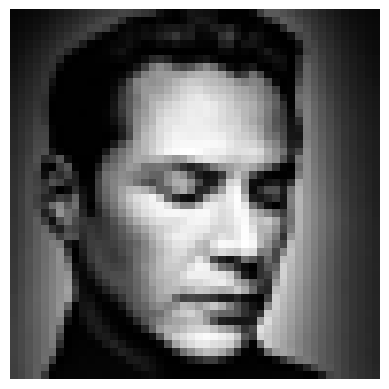

In [77]:
img = Image.open(file).convert('L')  # 흑백 변환
img = img.resize((48, 48))           # 크기 조정
img_array = np.array(img)            # NumPy 배열로 변환

# 2D 이미지 표시
plt.imshow(img_array, cmap='gray')  # 흑백 모드로 표시
plt.axis('off')                     # 축 제거
plt.show()



In [ ]:
from torchviz import make_dot
import torch

# GenCNN 클래스 인스턴스화
model = GenCNN()
x = torch.randn(1, 1, 48, 48)  # 입력 샘플 데이터
y = model(x)

# 모델 도식화
dot = make_dot(y, params=dict(list(model.named_parameters())))
dot.format = 'png'
dot.render('model_structure')  # 'model_structure.png'로 저장됩니다


'model_structure.png'